In [ ]:

import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# With additional metrics

In [ ]:
import tensorflow_datasets as tfds
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load and Preprocess Data
# Load the 'mnist_corrupted/identity' dataset and convert to numpy arrays

(dataset_train, dataset_test), dataset_info = tfds.load(
    'mnist_corrupted/identity',
    split=['train[:2000]', 'test[:2000]'],  # Restrict to 2000 samples each
    as_supervised=True,
    with_info=True
)

def dataset_to_numpy(dataset):
    image_list = []
    for image, _ in dataset:
        image_list.append(image.numpy())
    return np.array(image_list)

train_images_np = dataset_to_numpy(dataset_train)
test_images_np = dataset_to_numpy(dataset_test)

# Normalize images and convert to PyTorch tensors
train_images_tensor = torch.Tensor(train_images_np / 255.0).unsqueeze(1).squeeze(-1)
test_images_tensor = torch.Tensor(test_images_np / 255.0).unsqueeze(1).squeeze(-1)

# Create DataLoader objects
batch_size = 128
train_data = TensorDataset(train_images_tensor)
test_data = TensorDataset(test_images_tensor)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
# Construct the autoencoder with encoder and decoder networks

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate and move the model to device
autoencoder = AutoEncoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder.to(device)

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

In [ ]:
# Define loss function, optimizer, and train the model over epochs

loss_function = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

epochs = 30
train_losses = []

for epoch in range(epochs):
    autoencoder.train()
    cumulative_loss = 0.0
    for images, in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        reconstructed_images = autoencoder(images)
        loss = loss_function(reconstructed_images, images)
        loss.backward()
        optimizer.step()
        cumulative_loss += loss.item() * images.size(0)

    epoch_loss = cumulative_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/30], Loss: 0.2165
Epoch [2/30], Loss: 0.1329
Epoch [3/30], Loss: 0.1091
Epoch [4/30], Loss: 0.0797
Epoch [5/30], Loss: 0.0461
Epoch [6/30], Loss: 0.0348
Epoch [7/30], Loss: 0.0268
Epoch [8/30], Loss: 0.0193
Epoch [9/30], Loss: 0.0144
Epoch [10/30], Loss: 0.0118
Epoch [11/30], Loss: 0.0102
Epoch [12/30], Loss: 0.0091
Epoch [13/30], Loss: 0.0081
Epoch [14/30], Loss: 0.0074
Epoch [15/30], Loss: 0.0068
Epoch [16/30], Loss: 0.0063
Epoch [17/30], Loss: 0.0059
Epoch [18/30], Loss: 0.0056
Epoch [19/30], Loss: 0.0054
Epoch [20/30], Loss: 0.0051
Epoch [21/30], Loss: 0.0049
Epoch [22/30], Loss: 0.0047
Epoch [23/30], Loss: 0.0045
Epoch [24/30], Loss: 0.0044
Epoch [25/30], Loss: 0.0043
Epoch [26/30], Loss: 0.0041
Epoch [27/30], Loss: 0.0040
Epoch [28/30], Loss: 0.0039
Epoch [29/30], Loss: 0.0039
Epoch [30/30], Loss: 0.0038


In [ ]:
# Function to compute reconstruction errors for the dataset

def get_reconstruction_errors(model, loader):
    model.eval()
    errors = []
    with torch.no_grad():
        for images, in loader:
            images = images.to(device)
            reconstructed_images = model(images)
            loss = torch.mean((reconstructed_images - images) ** 2, dim=[1, 2, 3])
            errors.extend(loss.cpu().numpy())
    return np.array(errors)

# Calculate reconstruction errors for training data
train_recon_errors = get_reconstruction_errors(autoencoder, train_loader)

In [ ]:
# Calculate a dynamic threshold for anomaly detection

def dynamic_threshold_calculation(errors):
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    return mean_error + 2 * std_error

anomaly_threshold = dynamic_threshold_calculation(train_recon_errors)
print(f"Anomaly Detection Threshold: {anomaly_threshold}")


Anomaly Detection Threshold: 0.007743801223114133


In [ ]:

corruptions = [
    'identity', 'shot_noise', 'impulse_noise', 'glass_blur', 'motion_blur',
    'shear', 'scale', 'rotate', 'brightness', 'translate', 'stripe',
    'fog', 'spatter', 'dotted_line', 'zigzag'
]

all_predictions = []
all_ground_truth = []
all_recon_errors = []

for corruption_type in corruptions:
    print(f"Evaluating on corruption type: {corruption_type}")
    dataset_test, dataset_info = tfds.load(
        f'mnist_corrupted/{corruption_type}',
        split='test[:2000]',
        as_supervised=True,
        with_info=True
    )

    test_images_np = dataset_to_numpy(dataset_test)
    test_images_tensor = torch.Tensor(test_images_np / 255.0).unsqueeze(1).squeeze(-1)
    test_loader = DataLoader(TensorDataset(test_images_tensor), batch_size=batch_size, shuffle=False)

    recon_errors = get_reconstruction_errors(autoencoder, test_loader)
    all_recon_errors.extend(recon_errors)

    if corruption_type == 'identity':
        ground_truth_labels = np.zeros_like(recon_errors)
    else:
        ground_truth_labels = np.ones_like(recon_errors)

    predicted_labels = recon_errors > anomaly_threshold
    all_predictions.extend(predicted_labels)
    all_ground_truth.extend(ground_truth_labels)


Evaluating on corruption type: identity
Evaluating on corruption type: shot_noise
Evaluating on corruption type: impulse_noise
Evaluating on corruption type: glass_blur
Evaluating on corruption type: motion_blur
Evaluating on corruption type: shear
Evaluating on corruption type: scale
Evaluating on corruption type: rotate
Evaluating on corruption type: brightness
Evaluating on corruption type: translate
Evaluating on corruption type: stripe
Evaluating on corruption type: fog
Evaluating on corruption type: spatter
Evaluating on corruption type: dotted_line
Evaluating on corruption type: zigzag


In [ ]:
# Calculate and display the confusion matrix

all_predictions = np.array(all_predictions)
all_ground_truth = np.array(all_ground_truth)
conf_matrix = confusion_matrix(all_ground_truth, all_predictions)

TN, FP, FN, TP = conf_matrix.ravel()
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}")


Confusion Matrix:
[[ 1933    67]
 [ 8425 19575]]
TN: 1933, FP: 67, FN: 8425, TP: 19575


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


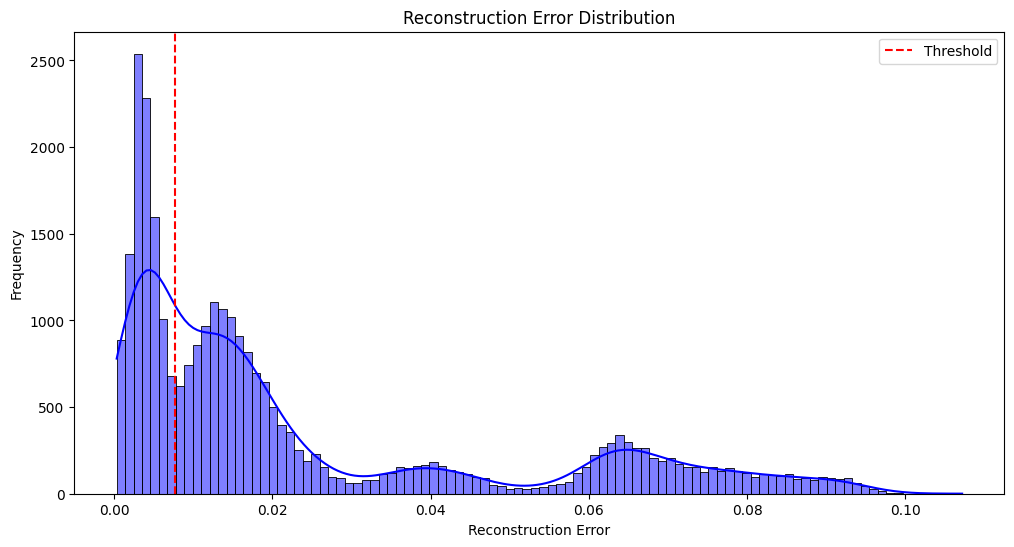

In [ ]:
# Plot reconstruction error distribution, original vs reconstructed images, and training loss

# Plot reconstruction error distribution
plt.figure(figsize=(12, 6))
plt.title('Reconstruction Error Distribution')
sns.histplot(all_recon_errors, bins=100, kde=True, color='blue')
plt.axvline(anomaly_threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
# Display original vs reconstructed images
for images, in train_loader:
    images = images.to(device)
    reconstructed_images = autoencoder(images)
    break  # Use a single batch for visualization

plt.figure(figsize=(12, 6))
plt.suptitle('Original vs Reconstructed Images', fontsize=16)
plt.show()

<Figure size 1200x600 with 0 Axes>

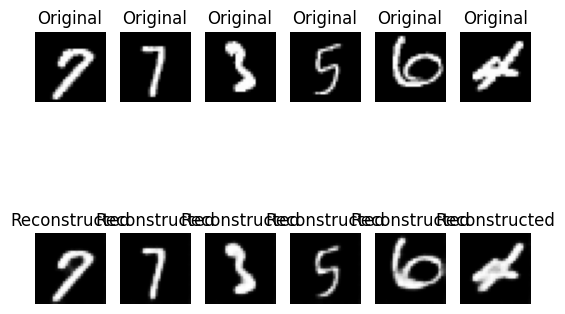

In [ ]:
# Plot original images
for i in range(6):
    plt.subplot(2, 6, i + 1)
    plt.imshow(images[i].cpu().detach().squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

# Plot reconstructed images
for i in range(6):
    plt.subplot(2, 6, i + 7)
    plt.imshow(reconstructed_images[i].cpu().detach().squeeze(), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()

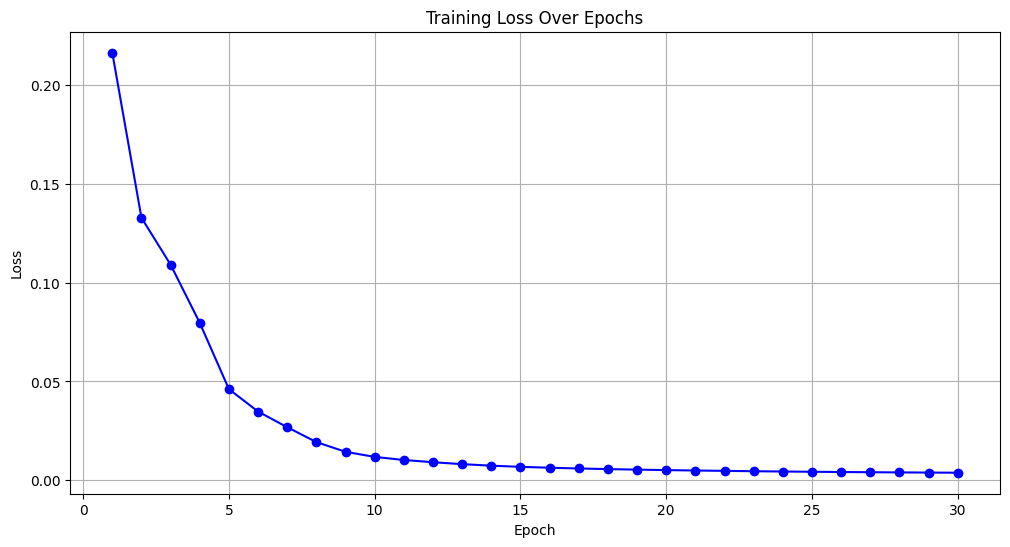

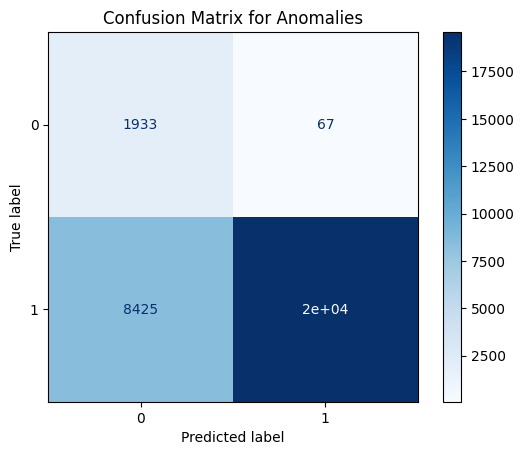

In [ ]:
# Plot training loss over epochs
plt.figure(figsize=(12, 6))
plt.title('Training Loss Over Epochs')
plt.plot(range(1, epochs + 1), train_losses, marker='o', linestyle='-', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

# Display confusion matrix for anomalies
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Anomalies')
plt.show()


## Without any Additional Metrics

In [ ]:
import tensorflow_datasets as tfds
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix

# Load the 'mnist_corrupted/identity' dataset
(ds_train, ds_test), ds_info = tfds.load(
    'mnist_corrupted/identity',  # Identity has no corruption
    split=['train[:2000]', 'test[:2000]'],  # Use only 2000 samples
    as_supervised=True,
    with_info=True
)

# Convert to numpy arrays
def to_numpy(ds):
    images = []
    for img, _ in ds:  # Ignore labels
        images.append(img.numpy())
    return np.array(images)

train_images = to_numpy(ds_train)
test_images = to_numpy(ds_test)

# Normalize images and convert to PyTorch tensors
train_images = torch.Tensor(train_images / 255.0).unsqueeze(1).squeeze(-1)  # Remove last dim
test_images = torch.Tensor(test_images / 255.0).unsqueeze(1).squeeze(-1)

# Create DataLoaders
batch_size = 128
train_dataset = TensorDataset(train_images)
test_dataset = TensorDataset(test_images)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model
model = Autoencoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Compute reconstruction errors for the training set
def compute_reconstruction_error(model, loader):
    model.eval()
    errors = []
    with torch.no_grad():
        for images, in loader:
            images = images.to(device)
            outputs = model(images)
            loss = torch.mean((outputs - images) ** 2, dim=[1, 2, 3])
            errors.extend(loss.cpu().numpy())
    return np.array(errors)

# Calculate reconstruction errors for training data
train_reconstruction_errors = compute_reconstruction_error(model, train_loader)

# Dynamic threshold calculation
def calculate_dynamic_threshold(losses):
    mean_loss = np.mean(losses)
    std_loss = np.std(losses)
    dynamic_threshold = mean_loss + 2 * std_loss  # Adaptive threshold using z-scores
    return dynamic_threshold

# Set an initial anomaly detection threshold based on the training loss distribution
threshold = calculate_dynamic_threshold(train_reconstruction_errors)
print(f"Initial anomaly detection threshold: {threshold}")

# Evaluate across all corruption types
corruption_types = [
    'identity', 'shot_noise', 'impulse_noise', 'glass_blur', 'motion_blur',
    'shear', 'scale', 'rotate', 'brightness', 'translate', 'stripe',
    'fog', 'spatter', 'dotted_line', 'zigzag'
]

all_predictions = []
all_ground_truth = []

for corruption in corruption_types:
    print(f"Evaluating corruption type: {corruption}")
    ds_test, ds_info = tfds.load(
        f'mnist_corrupted/{corruption}',
        split='test[:2000]',  # Use only 2000 samples
        as_supervised=True,
        with_info=True
    )

    test_images = to_numpy(ds_test)
    test_images = torch.Tensor(test_images / 255.0).unsqueeze(1).squeeze(-1)
    test_loader = DataLoader(TensorDataset(test_images), batch_size=batch_size, shuffle=False)

    # Compute reconstruction errors
    reconstruction_errors = compute_reconstruction_error(model, test_loader)

    # Create ground truth labels
    if corruption == 'identity':
        ground_truth = np.zeros_like(reconstruction_errors)  # Normal
    else:
        ground_truth = np.ones_like(reconstruction_errors)   # Anomalous

    # Make predictions
    predictions = reconstruction_errors > threshold
    all_predictions.extend(predictions)
    all_ground_truth.extend(ground_truth)

# Compute confusion matrix
all_predictions = np.array(all_predictions)
all_ground_truth = np.array(all_ground_truth)
cm = confusion_matrix(all_ground_truth, all_predictions)

# Extract TN, TP, FN, FP
TN, FP, FN, TP = cm.ravel()

print(f"Confusion Matrix:\n{cm}")
print(f"TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}")

Epoch [1/30], Loss: 0.1680
Epoch [2/30], Loss: 0.1025
Epoch [3/30], Loss: 0.0550
Epoch [4/30], Loss: 0.0374
Epoch [5/30], Loss: 0.0266
Epoch [6/30], Loss: 0.0194
Epoch [7/30], Loss: 0.0149
Epoch [8/30], Loss: 0.0123
Epoch [9/30], Loss: 0.0107
Epoch [10/30], Loss: 0.0094
Epoch [11/30], Loss: 0.0085
Epoch [12/30], Loss: 0.0077
Epoch [13/30], Loss: 0.0071
Epoch [14/30], Loss: 0.0066
Epoch [15/30], Loss: 0.0061
Epoch [16/30], Loss: 0.0058
Epoch [17/30], Loss: 0.0055
Epoch [18/30], Loss: 0.0052
Epoch [19/30], Loss: 0.0050
Epoch [20/30], Loss: 0.0048
Epoch [21/30], Loss: 0.0047
Epoch [22/30], Loss: 0.0045
Epoch [23/30], Loss: 0.0044
Epoch [24/30], Loss: 0.0043
Epoch [25/30], Loss: 0.0042
Epoch [26/30], Loss: 0.0041
Epoch [27/30], Loss: 0.0040
Epoch [28/30], Loss: 0.0039
Epoch [29/30], Loss: 0.0039
Epoch [30/30], Loss: 0.0038
Initial anomaly detection threshold: 0.007840525824576616
Evaluating corruption type: identity
Evaluating corruption type: shot_noise
Evaluating corruption type: impulse